In [7]:
import os 
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()    

2023-12-21 10:41:30.519 Python[24694:1694237] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [1]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/rahul_4real/.labelmerc
2023-12-21 10:51:15.796 Python[24971:1702013] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [8]:
import tensorflow as tf
import numpy as np
import json
from matplotlib import pyplot as plt

In [35]:
images = tf.data.Dataset.list_files(r'data/test/images/*.jpg', shuffle = False)

In [36]:
images.as_numpy_iterator().next()

b'data/test/images/2c6e64c4-9fc0-11ee-8c5e-2e2bb5702545.jpg'

In [9]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [38]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [40]:
image_generator = images.batch(4).as_numpy_iterator()

In [43]:
plot_images = image_generator.next()

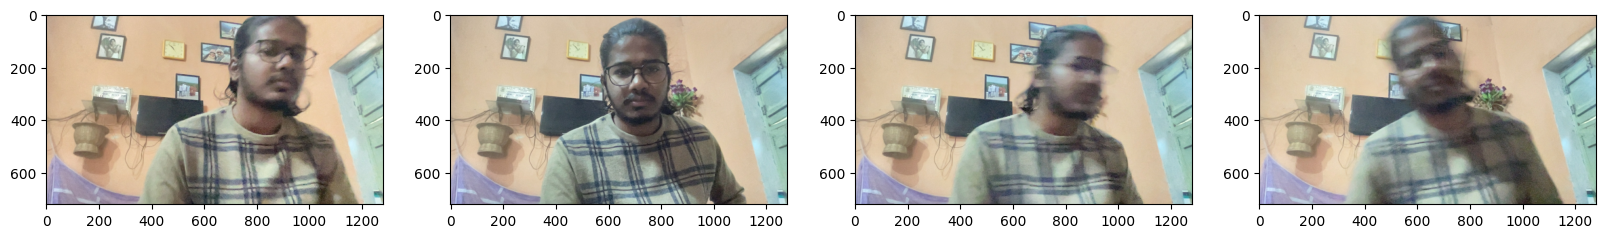

In [44]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [50]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)           

In [51]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/rahul_4real/.labelmerc
2023-12-21 18:02:01.067 Python[26619:1793347] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [52]:
img = cv2.imread(os.path.join('data','train','images','2cc01bac-9fc0-11ee-8c5e-2e2bb5702545.jpg'))

In [55]:
img.shape

(720, 1280, 3)

In [59]:
import albumentations as alb

In [60]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format = 'albumentations',
                                                 label_fields=['class_labels']))

In [61]:
img = cv2.imread(os.path.join('data', 'train', 'images', '3123e3c2-9fc0-11ee-8c5e-2e2bb5702545.jpg'))

In [80]:
with open(os.path.join('data', 'train', 'labels', '3123e3c2-9fc0-11ee-8c5e-2e2bb5702545.json'), 'r') as f:
    label = json.load(f)

In [81]:
label['shapes'][0]

{'label': 'face',
 'points': [[453.29113924050637, 231.51898734177217],
  [721.6455696202532, 469.4936708860759]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {}}

In [82]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [83]:
coords

[453.29113924050637, 231.51898734177217, 721.6455696202532, 469.4936708860759]

In [84]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [85]:
coords

[0.3541337025316456,
 0.32155414908579466,
 0.5637856012658229,
 0.6520745428973277]

In [86]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [157]:
augmented['bboxes'][0][:2]

(0.0, 0.0)

In [158]:
augmented['bboxes'][0]

(0.0, 0.0, 0.5716736990154713, 0.6565119549929677)

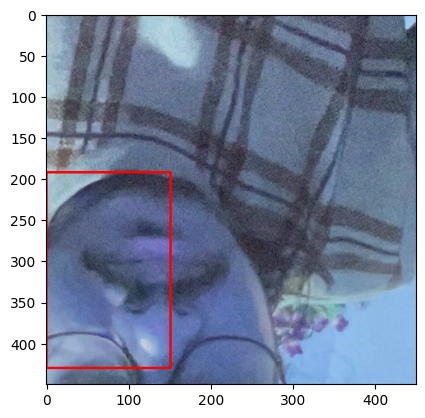

In [89]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [95]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords =[0,0,0.0001,0.0001]
        label_path = os.path.join('data', partition, 'labels', f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [1280, 720, 1280, 720]))
                
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes = [coords], class_labels = ['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f"{image.split('.')[0]}.{x}.jpg"),augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class']= 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class']= 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class']= 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
                    
        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type


In [10]:
train_images = tf.data.Dataset.list_files(r'aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files(r'aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [12]:
val_images = tf.data.Dataset.list_files(r'aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [13]:
train_images.as_numpy_iterator().next()

array([[[0.76188725, 0.76004905, 0.8050858 ],
        [0.7329657 , 0.7123774 , 0.7400122 ],
        [0.7106005 , 0.64846814, 0.671201  ],
        ...,
        [0.24644607, 0.15085784, 0.2572304 ],
        [0.30367646, 0.20857844, 0.3242647 ],
        [0.24871324, 0.15459558, 0.28498775]],

       [[0.76390934, 0.77794117, 0.82144606],
        [0.7525123 , 0.752451  , 0.79405636],
        [0.7531863 , 0.7237745 , 0.76795346],
        ...,
        [0.23835784, 0.14767157, 0.26286766],
        [0.24454656, 0.15232843, 0.27604166],
        [0.22414216, 0.13443628, 0.25845587]],

       [[0.75784314, 0.7852941 , 0.81960785],
        [0.7571691 , 0.7783701 , 0.8268995 ],
        [0.7538603 , 0.7608456 , 0.8113971 ],
        ...,
        [0.25992647, 0.17457108, 0.3129902 ],
        [0.22677696, 0.14442402, 0.27383578],
        [0.2608456 , 0.1711397 , 0.2981005 ]],

       ...,

       [[0.8403186 , 0.6324755 , 0.60110295],
        [0.83045346, 0.634375  , 0.606924  ],
        [0.8485907 , 0

In [14]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [15]:
train_labels = tf.data.Dataset.list_files(r'aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [16]:
test_labels = tf.data.Dataset.list_files(r'aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
val_labels = tf.data.Dataset.list_files(r'aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.7217, 0.2032, 1.    , 1.    ], dtype=float16))

In [19]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2940, 2940, 840, 840, 780, 780)

In [20]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [21]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [22]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [23]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3184, 0.    , 1.    , 0.8003],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.2106, 0.3936, 1.    ],
        [0.    , 0.    , 0.3586, 0.728 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.1301, 0.3022, 1.    ],
        [0.    , 0.1199, 0.4795, 1.    ],
        [0.0722, 0.3325, 0.9556, 0.9995]], dtype=float16))

In [24]:
data_samples = train.as_numpy_iterator()

In [25]:
res = data_samples.next()

In [26]:
res[1][1]

array([[0.    , 0.    , 0.    , 0.    ],
       [0.6787, 0.1643, 1.    , 0.817 ],
       [0.6875, 0.    , 1.    , 0.649 ],
       [0.575 , 0.562 , 1.    , 0.9165],
       [0.    , 0.682 , 0.699 , 1.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.4011, 1.    , 1.    ]], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


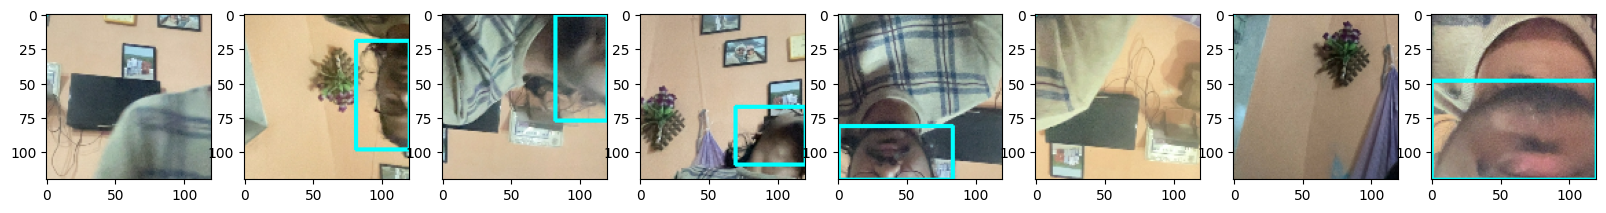

In [27]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8):
    sample_image = res[0][idx]
    sample_coords= res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (0,125,200), 2)
    ax[idx].imshow(sample_image)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dense
from tensorflow.keras.applications import VGG16

In [29]:
vgg = VGG16(include_top=False)

In [30]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [47]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top= False)(input_layer)
    #classfication
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = 'relu')(f1)
    class2 = Dense(1, activation = 'sigmoid')(class1)
    #bbox
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)
    
    facetracker = Model(inputs = input_layer, outputs = [class2, regress2])
    return facetracker

In [48]:
facetracker = build_model()

In [49]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [50]:
X, y = train.as_numpy_iterator().next()

In [51]:
X.shape

(8, 120, 120, 3)

In [52]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [53]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [54]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size


In [55]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [56]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [57]:
model = FaceTracker(facetracker)

In [58]:
model.compile(opt, classloss, regressloss)

In [59]:
logdir='logs'

In [60]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
368/368 [==============================] - 340s 921ms/step - total_loss: 0.3402 - class_loss: 0.0789 - regress_loss: 0.3008 - val_total_loss: 0.1223 - val_class_loss: 0.0045 - val_regress_loss: 0.1200
Epoch 2/10
368/368 [==============================] - 354s 958ms/step - total_loss: 0.2935 - class_loss: 0.0696 - regress_loss: 0.2587 - val_total_loss: 0.0325 - val_class_loss: 0.0037 - val_regress_loss: 0.0306
Epoch 3/10
368/368 [==============================] - 359s 973ms/step - total_loss: 0.2018 - class_loss: 0.0463 - regress_loss: 0.1786 - val_total_loss: 0.0702 - val_class_loss: 4.3953e-04 - val_regress_loss: 0.0700
Epoch 4/10
368/368 [==============================] - 360s 973ms/step - total_loss: 0.1549 - class_loss: 0.0374 - regress_loss: 0.1362 - val_total_loss: 0.0033 - val_class_loss: 8.1232e-04 - val_regress_loss: 0.0029
Epoch 5/10
368/368 [==============================] - 355s 959ms/step - total_loss: 0.0999 - class_loss: 0.0198 - regress_loss: 0.0901 - val_tot

In [63]:
hist.history

{'total_loss': [0.14285320043563843,
  0.03272790089249611,
  0.017788410186767578,
  0.08210818469524384,
  0.08710992336273193,
  0.00842991191893816,
  0.006031211465597153,
  0.005426438525319099,
  0.0048835743218660355,
  0.021867278963327408],
 'class_loss': [0.012102117761969566,
  0.012491272762417793,
  0.00427660159766674,
  0.00027293310267850757,
  0.013215716928243637,
  4.03553967771586e-05,
  0.002416204661130905,
  0.000894970609806478,
  4.0413637179881334e-05,
  1.4454142274189508e-06],
 'regress_loss': [0.13680213689804077,
  0.026482265442609787,
  0.015650108456611633,
  0.08197171986103058,
  0.08050206303596497,
  0.008409733884036541,
  0.0048231091350317,
  0.004978953395038843,
  0.004863367415964603,
  0.021866556257009506],
 'val_total_loss': [0.1222875565290451,
  0.032473161816596985,
  0.07024862617254257,
  0.003330048406496644,
  0.49479854106903076,
  0.605034589767456,
  0.05983418971300125,
  0.053894512355327606,
  0.061123307794332504,
  0.0004907

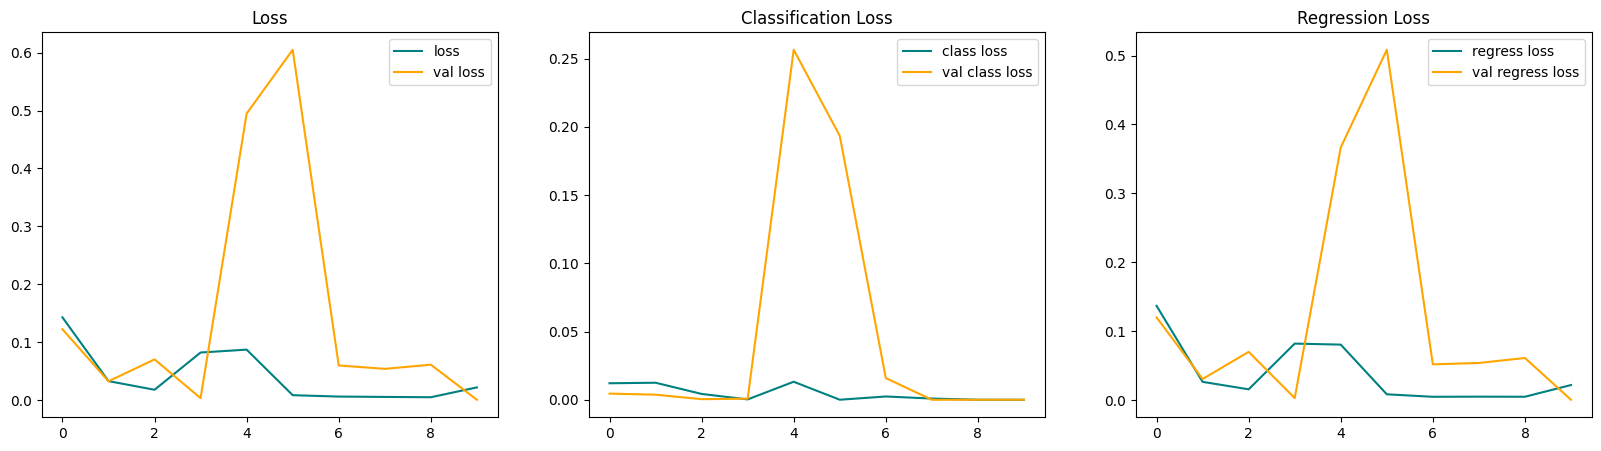

In [64]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


In [65]:
test_data = test.as_numpy_iterator()

In [75]:
test_sample = test_data.next()

In [76]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 232ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


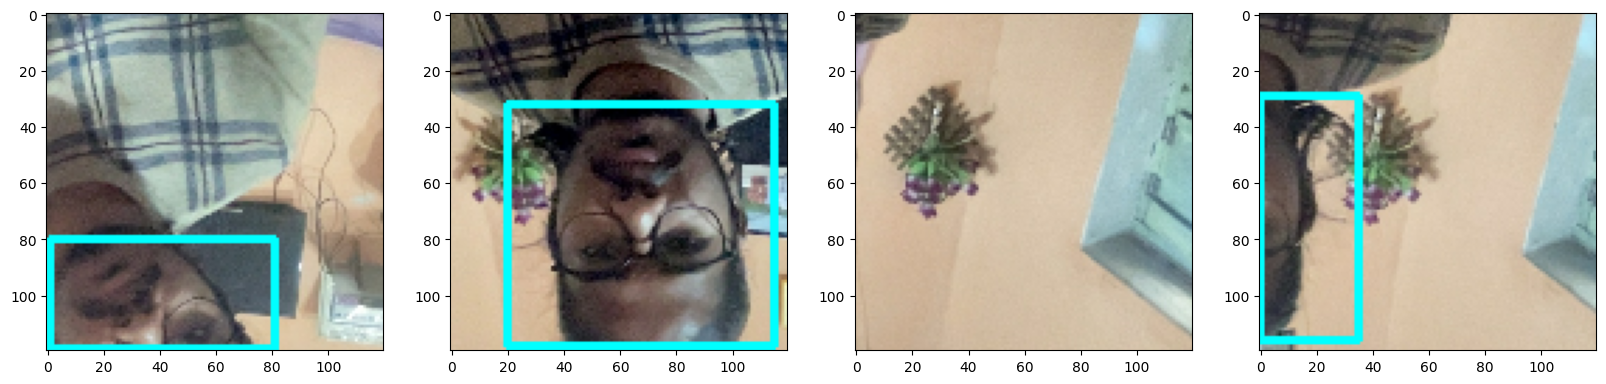

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (0,120,200), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
facetracker.save('facetracker.h5')